In [79]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.express as px

In [80]:
biometrics_df = df = pd.read_csv('biometrics_data.csv', delimiter=';')
biometrics_df.head()

,walking_type,video_id,person_id,camera_type,steps_length,avg_step_length,speed,time,distance,asymmetry
0,normal,athletic_male,1,front,[0.206535 0.16247936 0.15428336 0.16719694 0...,0.157053,0.336541,84,0.942315,3.557927
1,abnormal,limping_4,1,front,[0.32993475 0.25341373 0.25160984 0.25408458 0...,0.260952,0.387126,182,2.348565,18.524260
2,abnormal,limping_4,2,front,[0.21386674 0.21163296 0.20930154 0.2111826 0...,0.185687,0.361059,216,2.599625,15.970930
3,abnormal,cane1,1,front,[0.21219474 0.12049623 0.11709654 0.19381784 0...,0.172323,0.258485,240,2.067881,21.721027
4,abnormal,cane1,2,front,[0.15121503 0.15126347 0.15025296 0.15138295 0...,0.177433,0.342039,249,2.838926,39.067362


In [81]:
# Somehow the steps_length column is a string of a list of floats, so we need to convert it to a list of floats
biometrics_df["steps_length"] = biometrics_df["steps_length"].apply(
    lambda x: np.fromstring(x[1:-1], sep=" ")
)

# Rename side by side video
biometrics_df.loc[(biometrics_df['video_id'] == 'drunk_woman') & (biometrics_df['person_id'] == 0), 'camera_type'] = 'side'
biometrics_df.loc[(biometrics_df['video_id'] == 'drunk_woman') & (biometrics_df['person_id'] == 1), 'camera_type'] = 'front'

# Remove outlier
biometrics_df = biometrics_df[ (biometrics_df['video_id'] != 'DTU1') & (biometrics_df['asymmetry'] > -10.0)]

# Rename labels
replace = {"side2": "side", "front_multiple": "front", "back": "front", 'frontback': 'front'}
biometrics_df["camera_type"].replace(replace, inplace=True)

/var/folders/9m/g275tx_539v54jng1dk7_3m00000gn/T/ipykernel_31106/2498395683.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biometrics_df["camera_type"].replace(replace, inplace=True)


In [82]:
biometrics_df["walking_type"].unique()
biometrics_df["camera_type"].unique()

array(['front', 'side', 'side_front'], dtype=object)

In [83]:
"""
INPUT:
- condition: a text filter (e.g. "side", "front", "normal", "abnormal")
"""
condition = "normal"

In [84]:
clustering_df = biometrics_df.copy()
clustering_df["class"] = clustering_df["walking_type"] + "_" + clustering_df["camera_type"]
clustering_df["class"] = clustering_df["walking_type"]

# clustering_df = clustering_df[(clustering_df["camera_type"] == "front") | (clustering_df["camera_type"] == "side")]
clustering_df = clustering_df[(clustering_df["camera_type"] == "side")]

# clustering_df = clustering_df[clustering_df["camera_type"] == (condition)]
# clustering_df = clustering_df[clustering_df["walking_type"] == (condition)]

lustering_df = clustering_df[["class", "avg_step_length", "speed", "asymmetry"]]
clustering_df.head()


,walking_type,video_id,person_id,camera_type,steps_length,avg_step_length,speed,time,distance,asymmetry,class
10,normal,girl,1,side,"[0.77332369, 0.77441992, 0.76043908, 0.73235977]",0.760136,1.471230,62,3.040542,8.557317,normal
11,normal,happy_man,1,side,"[0.67112941, 0.67674865, 0.70010678, 0.6763788...",0.723013,1.351425,321,14.460252,49.292144,normal
14,abnormal,hemiplegic_gait2,1,side,"[0.46204626, 0.06862258, 0.5266334, 0.24097107...",0.326103,0.455651,365,5.543758,58.697831,abnormal
15,abnormal,antalgic_gait,1,side,"[0.54533748, 0.24525694, 0.58052247, 0.3933075...",0.450887,0.693672,156,3.607095,20.907722,abnormal
16,normal,jake,1,side,"[0.60958127, 0.56127467, 0.63991075, 0.6014579...",0.594405,1.229804,87,3.566431,11.525737,normal


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import accuracy_score

In [86]:
X_base = clustering_df[["avg_step_length", "speed", "asymmetry"]]
y_base = clustering_df[["class"]]

# X = X_base[y_base["class"].str.contains(condition)]
# y = y_base[y_base["class"].str.contains(condition)]

X = X_base
y = y_base

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [87]:
clf = svm.SVC(kernel="linear").fit(X_train, y_train)
accuracy_score(clf.predict(X_test), y_test)

# clf = KMeans(n_clusters=4)
# clf.fit(X_train, y_train)
# y_pred_test = kmeans.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [88]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import neural_network
import numpy as np


# Set up the classifier
# clf = svm.SVC(kernel="poly", degree=3)
clf = neural_network.MLPClassifier(hidden_layer_sizes=10, activation='relu', max_iter=2000, learning_rate_init=0.01, random_state=42)

# Set up the k-fold cross-validation
k_fold = 5 # You can choose the number of folds as per your requirement
combinations = [("avg_step_length", "speed"), ("avg_step_length", "asymmetry"), ("speed", "asymmetry")]
 
print("ALL")
# Perform k-fold cross-validation and get accuracy scores
# Use 'scoring' parameter to specify the scoring metric (default is accuracy)
scores = cross_val_score(clf, X, y["class"].ravel(), cv=k_fold, scoring=make_scorer(accuracy_score))
# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores)
# Print the mean and standard deviation of the accuracy scores
print("Mean accuracy:", np.mean(scores))
print("Standard deviation of accuracy:", np.std(scores))
print()

for i, (x_axis, y_axis) in enumerate(combinations):
    print((x_axis, y_axis))
    # Perform k-fold cross-validation and get accuracy scores
    # Use 'scoring' parameter to specify the scoring metric (default is accuracy)
    scores = cross_val_score(clf, X[[x_axis, y_axis]], y["class"].ravel(), cv=k_fold, scoring=make_scorer(accuracy_score))

    # Print the accuracy scores for each fold
    print("Accuracy scores for each fold:", scores)
    # Print the mean and standard deviation of the accuracy scores
    print("Mean accuracy:", np.mean(scores))
    print("Standard deviation of accuracy:", np.std(scores))
    print()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


ALL
Accuracy scores for each fold: [0.66666667 0.66666667 1.         1.         1.        ]
Mean accuracy: 0.8666666666666666
Standard deviation of accuracy: 0.16329931618554522

('avg_step_length', 'speed')
Accuracy scores for each fold: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0
Standard deviation of accuracy: 0.0

('avg_step_length', 'asymmetry')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Accuracy scores for each fold: [0.66666667 0.66666667 1.         1.         0.5       ]
Mean accuracy: 0.7666666666666666
Standard deviation of accuracy: 0.2

('speed', 'asymmetry')
Accuracy scores for each fold: [0.66666667 0.66666667 1.         1.         0.5       ]
Mean accuracy: 0.7666666666666666
Standard deviation of accuracy: 0.2



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


# KMeans

In [90]:
from sklearn.model_selection import cross_val_score, StratifiedKFold  # Import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np

# Set up the K-means clustering model
kmeans = KMeans(n_clusters=2, random_state=42)  # Change n_clusters as needed
# knn = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors

model = kmeans

# Map cluster labels to class labels
cluster_label_mapping = {0: 'abnormal', 1: 'normal'}  # Adjust as needed

# Set up the k-fold cross-validation
k_fold = 5 # You can choose the number of folds as per your requirement
combinations = [("avg_step_length", "speed"), ("avg_step_length", "asymmetry"), ("speed", "asymmetry")]

print("ALL")
# Perform k-fold cross-validation and get accuracy scores
# Use 'scoring' parameter to specify the scoring metric (default is accuracy)
scores = []
for train_idx, test_idx in StratifiedKFold(n_splits=k_fold, random_state=42, shuffle=True).split(X, y["class"]):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the K-means model on the training data
    model.fit(X_train)
    
    # Assign cluster labels to the test data
    cluster_labels = model.predict(X_test)
    
    # Map cluster labels to class labels
    predicted_labels = [cluster_label_mapping[label] for label in cluster_labels]
    
    # Evaluate accuracy based on class labels
    accuracy = accuracy_score(y_test["class"], predicted_labels)
    scores.append(accuracy)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores)
# Print the mean and standard deviation of the accuracy scores
print("Mean accuracy:", np.mean(scores))
print("Standard deviation of accuracy:", np.std(scores))
print()

for i, (x_axis, y_axis) in enumerate(combinations):
    print((x_axis, y_axis))
    # Perform k-fold cross-validation and get accuracy scores
    # Use 'scoring' parameter to specify the scoring metric (default is accuracy)
    scores = []
    for train_idx, test_idx in StratifiedKFold(n_splits=k_fold, random_state=42, shuffle=True).split(X[[x_axis, y_axis]], y["class"]):
        X_train, X_test = X[[x_axis, y_axis]].iloc[train_idx], X[[x_axis, y_axis]].iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit the K-means model on the training data
        model.fit(X_train)
        
        # Assign cluster labels to the test data
        cluster_labels = model.predict(X_test)
        
        # Map cluster labels to class labels
        predicted_labels = [cluster_label_mapping[label] for label in cluster_labels]
        
        # Evaluate accuracy based on class labels
        accuracy = accuracy_score(y_test["class"], predicted_labels)
        scores.append(accuracy)

    # Print the accuracy scores for each fold
    print("Accuracy scores for each fold:", scores)
    # Print the mean and standard deviation of the accuracy scores
    print("Mean accuracy:", np.mean(scores))
    print("Standard deviation of accuracy:", np.std(scores))
    print()


ALL
Accuracy scores for each fold: [0.6666666666666666, 0.0, 0.0, 0.0, 0.0]
Mean accuracy: 0.13333333333333333
Standard deviation of accuracy: 0.26666666666666666

('avg_step_length', 'speed')
Accuracy scores for each fold: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean accuracy: 0.0
Standard deviation of accuracy: 0.0

('avg_step_length', 'asymmetry')
Accuracy scores for each fold: [0.6666666666666666, 0.0, 0.0, 0.0, 0.0]
Mean accuracy: 0.13333333333333333
Standard deviation of accuracy: 0.26666666666666666

('speed', 'asymmetry')
Accuracy scores for each fold: [0.6666666666666666, 0.0, 0.0, 0.0, 0.0]
Mean accuracy: 0.13333333333333333
Standard deviation of accuracy: 0.26666666666666666



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

# GMM

In [97]:
from sklearn.model_selection import cross_val_score, StratifiedKFold  # Import StratifiedKFold
from sklearn.mixture import GaussianMixture  # Import GaussianMixture
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np

# Set up the Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)  # You can adjust the number of components

# Set up the k-fold cross-validation
k_fold = 5  # You can choose the number of folds as per your requirement
combinations = [("avg_step_length", "speed"), ("avg_step_length", "asymmetry"), ("speed", "asymmetry")]

print("ALL")
# Perform k-fold cross-validation and get accuracy scores
# Use 'scoring' parameter to specify the scoring metric (default is accuracy)
scores = []
for train_idx, test_idx in StratifiedKFold(n_splits=k_fold, random_state=42, shuffle=True).split(X, y["class"]):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit the GMM on the training data
    gmm.fit(X_train)
    
    # Predict cluster assignments for the test data
    cluster_assignments = gmm.predict(X_test)
    
    # Map cluster assignments to class labels
    unique_clusters = np.unique(cluster_assignments)
    cluster_label_mapping = {}
    for cluster in unique_clusters:
        cluster_samples = y_test["class"][cluster_assignments == cluster]
        most_frequent_label = cluster_samples.value_counts().idxmax()
        cluster_label_mapping[cluster] = most_frequent_label
    predicted_labels = [cluster_label_mapping[cluster] for cluster in cluster_assignments]
    
    # Evaluate accuracy based on class labels
    accuracy = accuracy_score(y_test["class"], predicted_labels)
    scores.append(accuracy)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", scores)
# Print the mean and standard deviation of the accuracy scores
print("Mean accuracy:", np.mean(scores))
print("Standard deviation of accuracy:", np.std(scores))
print()

for i, (x_axis, y_axis) in enumerate(combinations):
    print((x_axis, y_axis))
    # Perform k-fold cross-validation and get accuracy scores
    # Use 'scoring' parameter to specify the scoring metric (default is accuracy)
    scores = []
    for train_idx, test_idx in StratifiedKFold(n_splits=k_fold, random_state=42, shuffle=True).split(X[[x_axis, y_axis]], y["class"]):
        X_train, X_test = X[[x_axis, y_axis]].iloc[train_idx], X[[x_axis, y_axis]].iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit the GMM on the training data
        gmm.fit(X_train)
        
        # Predict cluster assignments for the test data
        cluster_assignments = gmm.predict(X_test)
        
        # Map cluster assignments to class labels
        unique_clusters = np.unique(cluster_assignments)
        cluster_label_mapping = {}
        for cluster in unique_clusters:
            cluster_samples = y_test["class"][cluster_assignments == cluster]
            most_frequent_label = cluster_samples.value_counts().idxmax()
            cluster_label_mapping[cluster] = most_frequent_label
        predicted_labels = [cluster_label_mapping[cluster] for cluster in cluster_assignments]
        
        # Evaluate accuracy based on class labels
        accuracy = accuracy_score(y_test["class"], predicted_labels)
        scores.append(accuracy)

    # Print the accuracy scores for each fold
    print("Accuracy scores for each fold:", scores)
    # Print the mean and standard deviation of the accuracy scores
    print("Mean accuracy:", np.mean(scores))
    print("Standard deviation of accuracy:", np.std(scores))
    print()


ALL
Accuracy scores for each fold: [0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.5]
Mean accuracy: 0.7666666666666666
Standard deviation of accuracy: 0.2

('avg_step_length', 'speed')
Accuracy scores for each fold: [0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.5]
Mean accuracy: 0.7666666666666666
Standard deviation of accuracy: 0.2

('avg_step_length', 'asymmetry')
Accuracy scores for each fold: [0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.5]
Mean accuracy: 0.7666666666666666
Standard deviation of accuracy: 0.2

('speed', 'asymmetry')
Accuracy scores for each fold: [0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.5]
Mean accuracy: 0.7666666666666666
Standard deviation of accuracy: 0.2



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# fig = px.scatter_3d(biometrics_df, x='avg_step_length', y='speed', z='asymmetry', color='camera_type', symbol='walking_type', width=1000, height=1000)
# fig.show()

['normal', 'abnormal']
normal
abnormal


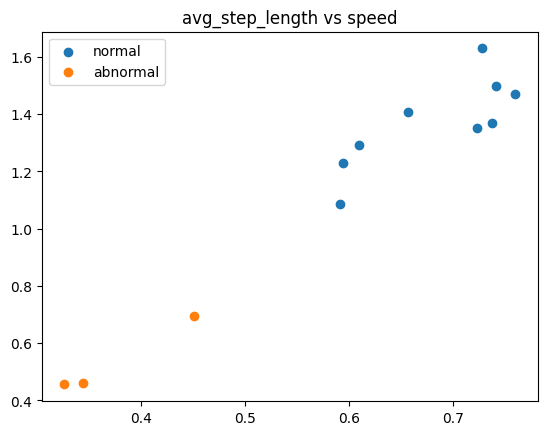

normal
abnormal


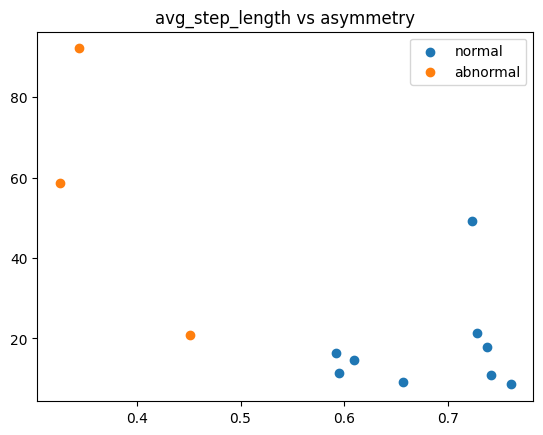

normal
abnormal


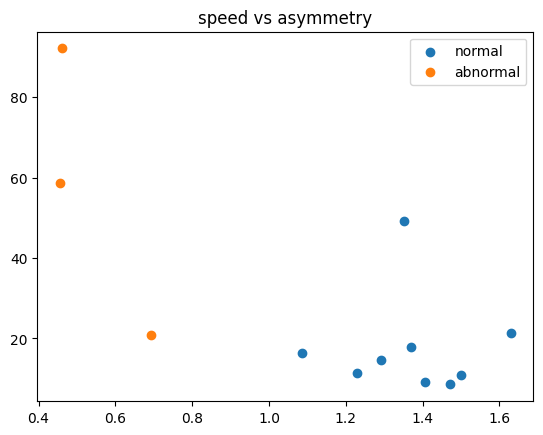

In [35]:
import matplotlib.pyplot as plt
import itertools


legend = list(clustering_df["class"].unique())
print(legend)

unique_numbers = {word: i for i, word in enumerate(set(clustering_df['class']))}

# Map the 'Fruit' column to unique numbers using the dictionary
clustering_df['numClass'] = clustering_df['class'].map(unique_numbers)

for item in itertools.combinations(["avg_step_length", "speed", "asymmetry"], r=2):
    fig, ax = plt.subplots()

    for class_label in legend:
        print(class_label)
        ax.scatter(clustering_df[clustering_df["class"] == class_label][item[0]], clustering_df[clustering_df["class"] == class_label][item[1]], label="class_label")

    ax.legend(legend)
    plt.title(item[0] + " vs " + item[1])
    plt.show()

In [36]:
biometrics_df.head()

,walking_type,video_id,person_id,camera_type,steps_length,avg_step_length,speed,time,distance,asymmetry
0,normal,athletic_male,1,front,"[0.206535, 0.16247936, 0.15428336, 0.16719694,...",0.157053,0.336541,84,0.942315,3.557927
1,abnormal,limping_4,1,front,"[0.32993475, 0.25341373, 0.25160984, 0.2540845...",0.260952,0.387126,182,2.348565,18.524260
2,abnormal,limping_4,2,front,"[0.21386674, 0.21163296, 0.20930154, 0.2111826...",0.185687,0.361059,216,2.599625,15.970930
3,abnormal,cane1,1,front,"[0.21219474, 0.12049623, 0.11709654, 0.1938178...",0.172323,0.258485,240,2.067881,21.721027
4,abnormal,cane1,2,front,"[0.15121503, 0.15126347, 0.15025296, 0.1513829...",0.177433,0.342039,249,2.838926,39.067362


/var/folders/9m/g275tx_539v54jng1dk7_3m00000gn/T/ipykernel_31106/3368684993.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["class"] = y
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/9m/g275tx_539v54jng1dk7_3m00000gn/T/ipykernel_31106/3368684993.py:110: UserWarning: Creating legend with loc="best" can be slow 

Accuracy: 0.50


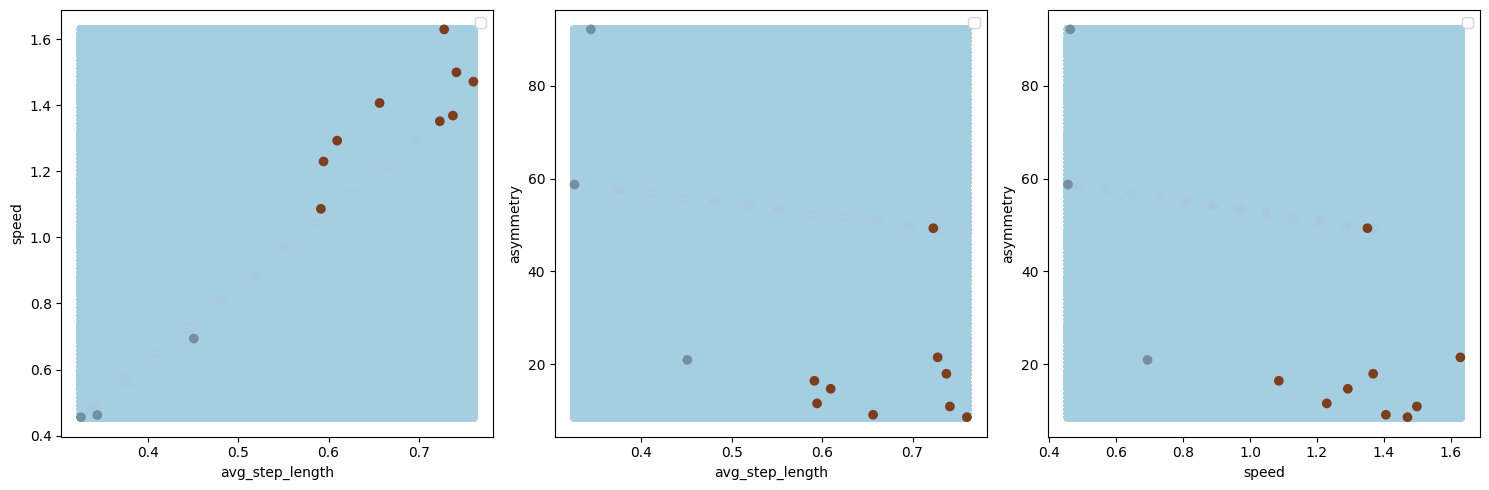

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# Assuming you have a DataFrame named clustering_df
# Here's how to load or create it
# clustering_df = pd.read_csv('your_data.csv')  # Load your data from a CSV file
# or
# clustering_df = pd.DataFrame(...)  # Create your DataFrame with your data

# Encode the 'class' column to numerical values
label_encoder = LabelEncoder()
clustering_df['class_encoded'] = label_encoder.fit_transform(clustering_df['class'])

# Train-test split
X = clustering_df[['avg_step_length', 'speed', 'asymmetry']]
y = clustering_df['class_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train an SVM classifier

poly = SVC(kernel='poly', degree=3).fit(X_train, y_train)
linear = SVC(kernel='linear').fit(X_train, y_train)
mlpClass = neural_network.MLPClassifier(hidden_layer_sizes=10, activation='relu', max_iter=2000, learning_rate_init=0.01, random_state=42)

gmm = GaussianMixture(n_components=2, random_state=42)  # You can adjust the number of components

clf = gmm
clf.fit(X_train)

# Create a 3D meshgrid for visualization
xx, yy, zz = np.meshgrid(
    np.linspace(X['avg_step_length'].min(), X['avg_step_length'].max(), 100),
    np.linspace(X['speed'].min(), X['speed'].max(), 100),
    np.linspace(X['asymmetry'].min(), X['asymmetry'].max(), 100)
)

# Create a DataFrame with meshgrid points
meshgrid_df = pd.DataFrame({
    'avg_step_length': xx.ravel(),
    'speed': yy.ravel(),
    'asymmetry': zz.ravel()
})

# Predict class labels for the meshgrid DataFrame
meshgrid_df['predicted_class'] = clf.predict(meshgrid_df)
meshgrid_df.sort_values('predicted_class')

X["class"] = y

X.sort_values("class")
y.sort_values()

# Pairwise combinations
combinations = [("avg_step_length", "speed"), ("avg_step_length", "asymmetry"), ("speed", "asymmetry")]

# Create subplots for visualizing decision boundaries in pairwise combinations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

def create_darker_colormap(base_cmap, alpha_scale):
    colors = base_cmap(np.arange(base_cmap.N))
    colors[:, :3] *= alpha_scale  # Adjust RGB values to make colors darker
    return LinearSegmentedColormap.from_list(base_cmap.name + "_darker", colors, base_cmap.N)
    
darker_cmap = create_darker_colormap(plt.cm.Paired, alpha_scale=0.7)  # Adjust alpha_scale as needed

for i, (x_axis, y_axis) in enumerate(combinations):
    x_pairwise = meshgrid_df[[x_axis, y_axis]]
    
    # Plot decision boundary based on the predicted class of meshgrid points
    axes[i].scatter(
        meshgrid_df[x_axis],
        meshgrid_df[y_axis],
        c=meshgrid_df['predicted_class'],
        cmap=plt.cm.Paired,
        # marker='.',
        alpha=0.002
    )
    
    # for j, cls in enumerate(y.unique()):
    #     indices = (y == cls)
    #     axes[i].scatter(
    #         X.loc[indices, x_axis],
    #         X.loc[indices, y_axis],
    #         c=X.loc[indices, "class"],
    #         cmap=plt.cm.Paired,
    #         label=f'Class {cls}',
    #         alpha=1
    #     )

    axes[i].scatter(
        X[x_axis],
        X[y_axis],
        c=X["class"],
        cmap=darker_cmap,
        alpha=1,
    )

    axes[i].set_xlabel(x_axis)
    axes[i].set_ylabel(y_axis)
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Calculate accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.show()
